In [66]:
import jax.numpy as np
from jax import random, vmap, grad, jit
from jax.flatten_util import ravel_pytree

from functools import partial
from tqdm import trange
import numpy.random as npr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

In [48]:
class SGD():
  def __init__(self, learning_rate = 1e-3):
    self.learning_rate = learning_rate

  def step(self, params, grad):
    params_flat, unravel = ravel_pytree(params)
    grad_flat, _ = ravel_pytree(grad)
    params_flat = params_flat - self.learning_rate*grad_flat
    return unravel(params_flat)

In [68]:
class LinearRegression():
  def __init__(self, X, y, rng_key):
    # Normalize data
    self.Xmean, self.Xstd = X.mean(0), X.std(0)
    self.Ymean, self.Ystd = y.mean(0), y.std(0)
    X = (X - self.Xmean)/self.Xstd
    y = (y - self.Ymean)/self.Ystd

    # Store the normalized trainind data
    self.X = X
    self.y = y
    self.dim = X.shape[1]

    # Initialize the linear regression model
    self.init, self.apply = self.init_linear_regression(self.dim)
    self.params = self.init(rng_key)

    # Create optimizer
    self.optimizer = SGD(learning_rate=1e-4)

    # Logger to monitor the loss function
    self.loss_log = []

  def init_linear_regression(self, dim):
    def _init(rng_key):
      w = random.normal(rng_key, (dim,))
      logsigma = -4.0 # Tip: use sigma = np.exp(logsigma) to constrain sigma to be positive!
      params = {'weights': w, 'noise_logvar': logsigma}
      return params
    def _apply(params, input):
      w = params['weights']
      out = np.dot(input, w)
      return out
    return _init, _apply

  def per_example_loglikelihood(self, params, batch):
    X, y = batch
    y_pred = self.apply(params, X)
    sigma_sq = np.exp(params['noise_logvar'])
    loss = 0.5*np.log(2.0*np.pi*sigma_sq) + \
           0.5*(y - y_pred)**2/sigma_sq
    return loss

  def loss(self, params, batch):
    # Implementation #1
    pe_loss = lambda x: self.per_example_loglikelihood(params, x)
    loss = np.sum(vmap(pe_loss)(batch))
    # Implementation #2
    # loss = vmap(self.per_example_loglikelihood, in_axes = (None, 1))(params, batch)
    return loss

  @partial(jit, static_argnums=(0,))
  def step(self, params, batch):
    g = grad(self.loss, 0)(params, batch)
    params = self.optimizer.step(params, g)
    return params

  def data_stream(self, n, num_batches, batch_size):
    rng = npr.RandomState(0)
    while True:
      perm = rng.permutation(n)
      for i in range(num_batches):
        batch_idx = perm[i*batch_size:(i+1)*batch_size]
        yield self.X[batch_idx, :], self.y[batch_idx]

  def train(self, num_epochs = 100, batch_size = 64):   
    n = self.X.shape[0]
    num_complete_batches, leftover = divmod(n, batch_size)
    num_batches = num_complete_batches + bool(leftover) 
    batches = self.data_stream(n, num_batches, batch_size)
    params = self.params
    pbar = trange(num_epochs)
    for epoch in pbar:
      for _ in range(num_batches):
        batch = next(batches)
        params = self.step(params, batch)
      self.params = params
      loss_value = self.loss(params, batch)
      self.loss_log.append(loss_value)
      pbar.set_postfix({'Loss': loss_value})

  def predict(self, params, X_star):
    X_star = (X_star - self.Xmean)/self.Xstd
    pred_fn = lambda x: self.apply(params, x)
    y_pred = vmap(pred_fn)(X_star)
    y_pred = y_pred*self.Ystd + self.Ymean
    return y_pred

In [69]:
def f(x):
  x1, x2 = x[0], x[1]
  y = np.sqrt(3.0)*x1 + 2.0*x2
  return y

In [70]:
rng_key = random.PRNGKey(0)

d = 2
n = 500
noise = 0.1

# Create training data
X = random.uniform(rng_key, (n, d))
y = vmap(f)(X)
y = y + noise*y.std(0)*random.normal(rng_key, y.shape)

# Create test data
nn = 50
xx = np.linspace(0, 1, nn)
yy = np.linspace(0, 1, nn)
XX, YY = np.meshgrid(xx, yy)
X_star = np.concatenate([XX.flatten()[:,None], YY.flatten()[:,None]], axis = 1)
y_star = vmap(f)(X_star)

In [71]:
model = LinearRegression(X, y, rng_key)

In [72]:
model.train(num_epochs = 1000, batch_size = 64)

100%|██████████| 1000/1000 [00:41<00:00, 23.98it/s, Loss=-45.022232]


In [65]:
opt_params = model.params
print(opt_params)
y_pred = model.predict(opt_params, X_star)

{'noise_logvar': DeviceArray(-4.6108117, dtype=float32), 'weights': DeviceArray([0.64052105, 0.7799638 ], dtype=float32)}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


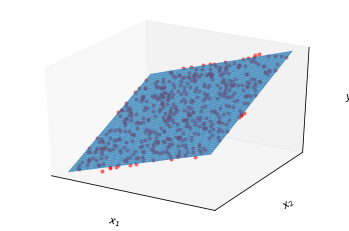

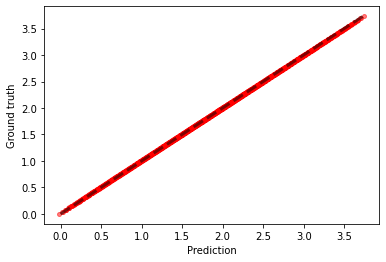

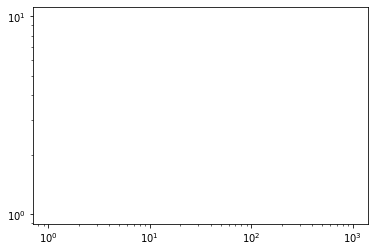

In [67]:
Yplot = griddata(X_star, y_pred, (XX, YY), method='cubic')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(X[:,0], X[:,1], y, 'r.', ms = 6, alpha = 0.5)
ax.plot_surface(XX, YY, Yplot, alpha = 0.8)
# Hide grid lines
ax.grid(False)
# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$y$')

plt.figure()
plt.plot(y_pred, y_star, 'r.', ms = 8, alpha = 0.5)
plt.plot(y_star, y_star, 'k--', lw = 3, alpha = 0.5)
plt.xlabel('Prediction')
plt.ylabel('Ground truth')

plt.figure()
plt.plot(model.loss_log)
plt.yscale('log')
plt.xscale('log')